# Statystyka matematyczna - ćwiczenia laboratoryjne 2023/2024

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi i wytyczne ogólne dotyczące uzupełniania notatnika:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce notatnika.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> `# YOUR CODE HERE`<br/> `raise NotImplementedError()`<br/> 
a odpowiedzi tekstowe w komórkach oznaczonych hasłem:<br/> 
`YOUR ANSWER HERE`<br/> 
Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz innych elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Otrzymywane wyniki i odpowiedzi mają być rezultatem wykonania napisanego kodu.
- Zadanie należy wykonać w taki sposób, aby podczas wykonywania kodu nie zostały wyświetlone żadne ostrzeżenia.
- Zawarte w notatniku automatyczne testy mają charakter poglądowy. Dotyczą one wybranych aspektów zadań i mają za zadanie wyłapać podstawowe błędy. Przejście wszystkich testów nie oznacza, że zadanie jest wykonane w całości poprawnie.

Uwagi i wytyczne ogólne dotyczące wizualizacji wyników:
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, posiadać odpowiednio dobrane proporcje i zakresy wartości osi.
- Wykresy oraz ich osie powinny mieć nadane tytuły. Jeżeli w obrębie figury znajduje się więcej niż jeden wykres to figura również powinna mieć nadany tytuł. 
- Figury powinny mieć ustawione białe tło, tak, aby niezależnie od ustawień notatnika wszystkie elementy wykresów były dobrze widoczne (domyślnie tło jest przeźroczyste co może powodować problemy w notatnikach z ustawionym ciemnym tłem).
- Rozmiar poziomy figur nie powinien przekraczać 20 cali.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (nazwa zespołu oraz imiona, nazwiska i numery indeksów członków zespołu) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$.

Nazwa zespołu:
Członkowie: Szymon Skrzypczyk 414609

---

# Zestaw zadań 10: Weryfikacja hipotez statystycznych - testy nieparametryczne

In [15]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów

### Funkcje do wykorzystania

In [17]:
def vizualize_test_result(pdf, statistic, rejection_region):
    """
    Parameters
    -------
    pdf: pandas.DataFrame
        Tablica zawierająca informacje niezbędne do wykreślenia funkcji gęstości prawdopodobieństwa wykorzystywanego w teście rozkładu
        teoretycznego - index z wariantami zmiennej losowej i nadaną nazwą zmiennej (np. x) oraz pojedynczą kolumnę z wartościami
        gęstościami prawdopodobieństwa wyliczonymi dla poszczególnych wariantów o nadanej nazwie bazującej na nazwie zmiennej (np. f(x)).
    statistic: float
        Wartość statystyki testowej wyliczonej na podstawie próby losowej.
    rejection_region: list
        Lista zawierająca trzy elementy pozwalające na określenie obszaru krytycznego w następującej kolejności:
         - wartość dolnej granicy przedziału,
         - wartość górnej granicy przedziału,
         - "inner" lub "outer" w zależności od tego, czy ma być zakolorowana wewnętrzna, czy zewnętrzna część przedziału.
    """
    pdf_name= pdf.columns[0]
    
    fig, axes = plt.subplots(1, 1, figsize=(8, 3), facecolor='white')

    axes.plot(pdf.index, pdf[pdf_name], color="grey")

    if rejection_region[2]=="inner":
        axes.fill_between(pdf.index, pdf[pdf_name], 0, where=((pdf.index > rejection_region[0]) & (pdf.index<rejection_region[1])), color='red', alpha=0.5)
    elif rejection_region[2]=="outer":
        axes.fill_between(pdf.index, pdf[pdf_name], 0, where=((pdf.index < rejection_region[0]) | (pdf.index>rejection_region[1])), color='red', alpha=0.5)
    
    axes.vlines(x=statistic, ymin=0, ymax=np.max(pdf[pdf_name]/3), color="blue")
    
    axes.set_xlabel(pdf.index.name)
    axes.set_ylabel(pdf_name)

### Zadanie 1: Test zgodności chi-kwadrat [10 pkt]

Zmienna `sample` zawiera wyniki 50 krotnego powtórzenia doświadczenia, w którym rzucamy monetą 20 razy i zapisujemy liczbę orłów, które wypadły w serii rzutów.

Przygotuj dane oraz napisz funkcję `chi2_homogeneity_NHST()`, która zostanie wykorzystana do weryfikacji hipotezy, że wykorzystana w doswiadczeniu moneta była uczciwa (prawdopodobieństwo wyrzucenia orła i reszki jest równe).

In [18]:
sample = np.array([ 9, 10, 11, 11,  8,  7, 14,  7, 14, 12,
                   14, 11,  9, 11, 15, 14, 11, 12,  8, 13,
                    9, 12,  7,  8, 10,  9, 14,  9,  8, 11,
                    8, 10,  5, 10,  8, 10, 13, 10, 14, 10,
                    8,  9, 14, 14,  8, 10,  9, 13, 10, 14])

#### a) Przygotowanie danych

Oblicz prawdopodobieństwa wystąpienia określonej liczby sukcesów (0, 1, 2 ...) w 20 niezależnych powtórzeniach doświaczenia o prawdopodobieństwie sukcesu równym 0.5. Wyniki zestaw w tabeli `theoretical_distribution` o następującej strukturze:

> Indeks:</br>
> x - warianty przyjmowane przez zmienną X.</br>

> Kolumny:</br>
> P(x) - prawdopodobieństwo wystąpienia poszczególnych wariantów.

Przygotuj szereg rozdzielczy wystąpienia określonej liczby orłów w seriach 20 rzutów monetą. Wyniki zestaw w tabeli `tested_distribution` o następującej strukturze:

> Indeks:</br>
> x - warianty przyjmowane przez zmienną X (identyczne jak w poprzedniej tablicy).</br>

> Kolumny:</br>
> N(x) - zliczenia wystąpienia poszczególnych wariantów.

In [19]:
possible_successes = np.arange(0, 21)  # do 21 bo jest prawostronnie otwarty przedzial

values = []

for i in possible_successes:
    values.append(sp.stats.binom.pmf(i, 20, 0.5))

theoretical_distribution = pd.DataFrame({"P(x)": values}, index=possible_successes)
theoretical_distribution.index.name = "x"
theoretical_distribution

,P(x)
x,
0,9.536743e-07
1,1.907349e-05
2,1.811981e-04
3,1.087189e-03
4,4.620552e-03
5,1.478577e-02
6,3.696442e-02
7,7.392883e-02
8,1.201344e-01


In [20]:
# Komórka testowa
assert type(theoretical_distribution) == pd.DataFrame
assert theoretical_distribution.shape == (21, 1)
assert list(theoretical_distribution.columns) == ["P(x)"]
assert theoretical_distribution.index.name == 'x'
assert np.isclose(np.sum(theoretical_distribution.index.values), 210)
assert np.isclose(np.sum(theoretical_distribution["P(x)"]), 1)

In [21]:
# uzywamy tego samego array

values_tested = []

for i in possible_successes:
    values_tested.append(np.sum(i == sample))

tested_distribution = pd.DataFrame({"N(x)": values_tested}, index=possible_successes)
tested_distribution.index.name = "x"
tested_distribution

,N(x)
x,
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,3
8,8


In [22]:
# Komórka testowa
assert type(tested_distribution) == pd.DataFrame
assert tested_distribution.shape == (21, 1)
assert list(tested_distribution.columns) == ["N(x)"]
assert tested_distribution.index.name == 'x'
assert np.isclose(np.sum(tested_distribution.index.values), 210)
assert np.isclose(np.sum(tested_distribution["N(x)"]), 50)

#### b) Test zgodności chi-kwadrat

Przygotuj funkcję `chi2_NHST()`, która będzie weryfikować test zgodności chi-kwadrat i wyświetlać wynik testu statystycznego zgodnie z wytycznymi zawartymi w dołączonym do notatnika zestawie wzorów, w treści zadania oraz w docstring funkcji.

Poza zwracaniem zmiennych wymienionych w docsting funkcji, które są potrzebne do przeprowadzenia automatycznych testów funkcji powinna wykorzystywać udostępnioną na początku notatnika funkcję `vizualize_test_result()` do generowania wykresu zawierającego:
- funkcję gęstości prawdopodobieństwa rozkładu teoretycznego wykorzystywanego w teście w zakresie od wartości, dla której dystrybuanta tego rozkładu przyjmuje wartość 0.0001 do wartości, dla której dystrybuanta tego rozkładu przyjmuje wartość 0.9999,
- zaznaczony wyróżniającym się kolorem fragmentem pola pod krzywą odpowiadający wyznaczonemu w teście obszarowi krytycznemu,
- wyróżniającą się kolorem pionowę linię wskazującą obliczoną wartość statystyki.

In [36]:
def chi2_NHST(tested_distribution, theoretical_distribution, alpha):
    """
    Parameters
    -------
    tested_distribution: DataFrame
        Tablica zawierająca indeks o nazwie "x" z wariantami zmiennej w próbie losowej oraz kolumnę "N(x)" z zliczeniami wariantów.
    theoretical_distribution: DataFrame
        Tablica zawierająca indeks o nazwie "x" z wariantami zmiennej teoretycznej oraz kolumnę "P(x)" z prawdopodobieństwami wariantów.
    alpha: float
        Wartość określająca poziom istotności.
    
    Returns
    -------
    chi2: float
        Wyliczona na podstawie próby losowej wartość statystyki chi2.
    chi2_alpha: float
        Wartość statystyki chi2_alpha.
    H: int
        Wynik testu statystycznego, przyjmuje wartość:
        0 - gdy wynik testu istotności nie daje podstaw do odrzucenia H0 na rzecz H1 na poziomie istotności 1-alpha,
        1 - gdy następuje odrzucenie H0 na rzecz H1 na poziomie istotności 1-alpha.
    """
    # wyciagamy potrzebne kolumny z dataframe'ow
    observed = tested_distribution['N(x)']
    # mnozymy przez laczna liczbe obserwacji, aby uzyskac potrzebna liczbe obserwacji(skalujemy)
    expected = theoretical_distribution['P(x)'] * np.sum(observed)
    # uzywamy funckji z pakietu scipy do wykonania testu
    # mialem juz zostawic z funkcja z pakietu
    chi2, _ = sp.stats.chisquare(observed, expected)
    
    # wyliczamy chi2_alpha z funckji ppf z pakietu scipy
    chi2_alpha = sp.stats.chi2.ppf(1 - alpha, len(tested_distribution) - 1)

    lower_bound = sp.stats.chi2.ppf(0.0001, len(tested_distribution) - 1)
    upper_bound = sp.stats.chi2.ppf(0.9999, len(tested_distribution) - 1)
    x = np.linspace(lower_bound, upper_bound, 1000)
    pdf = sp.stats.chi2.pdf(x, len(tested_distribution) - 1)
    _df = pd.DataFrame({'pdf': pdf}, index=x)
    _df.index.name = "x"

    vizualize_test_result(_df, chi2, [chi2_alpha,
                                        np.inf,
                                        "inner"])
    
    # Sprawdzenie wyniku testu
    H = 1 if chi2 > chi2_alpha else 0


    return chi2, chi2_alpha, H

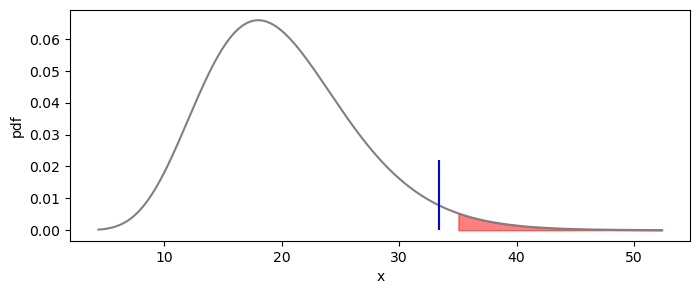

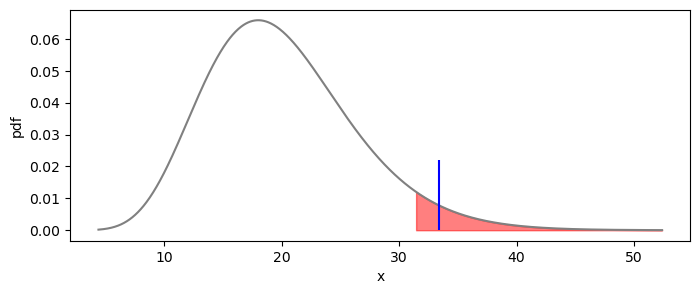

In [37]:
# Komórka testowa
assert np.all(np.isclose(chi2_NHST(tested_distribution, theoretical_distribution, 0.02), (33.3612131026868, 35.01962554059928, 0)))
assert np.all(np.isclose(chi2_NHST(tested_distribution, theoretical_distribution, 0.05), (33.3612131026868, 31.410432844230918, 1)))

### Zadanie 2: Weryfikacja hipotez z wykorzystaniem dedykowanych funkcji [5-10 pkt]

Zmienna `penguins` zawiera wyniki badań przeprowadzonych na pingwinach trzech różnych gatunków.

In [25]:
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


#### a) 

Korzystając z funkcji `scipy.stats.shapiro()` zweryfikuj hipotezę, że głębokość dzioba pingwinów gatunku Gentoo ma rozkład normalny. W obliczeniach przyjmij poziom istotności 1 - alpha = 0.95.

Zapisz obliczoną wartość pvalue do zmiennej `pvalue_1`, oraz przygotuj zmienną `H_1` zawierającą wynik testu statystycznego (0 - gdy wynik testu istotności nie daje podstaw do odrzucenia H0 na rzecz H1 na poziomie istotności 1-alpha, 1 - gdy następuje odrzucenie H0 na rzecz H1 na poziomie istotności 1-alpha).

Uwagi do wykonania zadania:
 - ustaw następującą wartość argumentu funkcji wykonującej test statystyczny odpowiedzialnego za radzenie sobie z wartościami nan: `nan_policy="omit"`.

In [26]:
# nie potrzebujemy 1 zwracanej wartosci
# wybieramy odpowiedni gatunek i kolumne
_, pvalue_1 = sp.stats.shapiro(penguins[penguins['species'] == 'Gentoo']['bill_depth_mm'], nan_policy="omit")

# przeprowadzamy test statystyczny dla alpha = 0.05
H_1 = 1 if pvalue_1 < 0.05 else 0

In [27]:
# Komórka testowa
assert np.isclose(pvalue_1, 0.027695094782335943)
assert H_1 == 1

#### b) 

Korzystając z funkcji `scipy.stats.ks_1samp()` lub `scipy.stats.kstest()` zweryfikuj hipotezę, że długość skrzydeł pingwinów gatunku Adelie ma rozkład normalny o wartości oczekiwanej 190 i odchyleniu standardowym 6. W obliczeniach przyjmij poziom istotności 1 - alpha = 0.9.

Zapisz obliczoną wartość pvalue do zmiennej `pvalue_2`, oraz przygotuj zmienną `H_2` zawierającą wynik testu statystycznego (0 - gdy wynik testu istotności nie daje podstaw do odrzucenia H0 na rzecz H1 na poziomie istotności 1-alpha, 1 - gdy następuje odrzucenie H0 na rzecz H1 na poziomie istotności 1-alpha).

Uwagi do wykonania zadania:
 - ustaw następującą wartość argumentu funkcji wykonującej test statystyczny odpowiedzialnego za radzenie sobie z wartościami nan: `nan_policy="omit"`.

In [28]:
# wywolujemy fukncje wybierajac rozklad normalny, wartosc oczekiwana 190 i std 6
_, pvalue_2 = sp.stats.kstest(penguins[penguins["species"] == "Adelie"]["flipper_length_mm"], cdf="norm", args=(190, 6), nan_policy="omit")

# przeprowadzamy test dla alpha = 0.1
H_2 = 1 if pvalue_2 < 0.1 else 0

In [29]:
# Komórka testowa
assert np.isclose(pvalue_2, 0.4388010272246816)
assert H_2 == 0

#### c) 

Korzystając z funkcji `scipy.stats.chisquare()` zweryfikuj hipotezę, że długość skrzydeł pingwinów gatunku Adelie ma rozkład normalny o wartości oczekiwanej 190 i odchyleniu standardowym 6. W obliczeniach przyjmij poziom istotności 1 - alpha = 0.9.

Zapisz obliczoną wartość pvalue do zmiennej `pvalue_3`, oraz przygotuj zmienną `H_3` zawierającą wynik testu statystycznego (0 - gdy wynik testu istotności nie daje podstaw do odrzucenia H0 na rzecz H1 na poziomie istotności 1-alpha, 1 - gdy następuje odrzucenie H0 na rzecz H1 na poziomie istotności 1-alpha).

Schemat wykonania zadania:

Uwagi do wykonanai zadania:
 - korzystając z funkcji `numpy.arange()` lub `numpy.linspace()` przygotuj macierz z granicami następujących przedziałów: [170, 173), [173, 176), ... , [209, 212],
 - korzystając z fukcji `numpy.histogram()` podziel zakres danych i zlicz ile wartości badanej cechy znajduje się w każdym z przedziałów,
 - korzystając z funkcji modułu `scipy.stats.norm` oblicz jakie jest prawdopodobieństwo wylosowania wartości z poszczególnych przedziałów dla testowanego rozkładu normalnego,
 - przelicz prawdopodobieństwa na liczebności toretyczne (ustandaryzuj je do sumy równej liczebności testowanego zestawu danych),
 - wykonaj test statystyczny korzysztając z funkcji `scipy.stats.chisquare()`.

In [94]:
# tworzymy przedzialy 
bins = np.arange(170, 213, 3)
# uzywamy funckji histogram i pomijamy 2 zwracana wartosc(bin_edges)
observed, _ = np.histogram(penguins[penguins['species'] == 'Adelie']['flipper_length_mm'], bins=bins)
# wyliczamy prawdopodobienstwo z funckji cdf rozkladu normlanego
# odejmujemy prawdopodobienstwa, aby sprawdzic, ze nasza zmienna losowa znajdzie sie w oczekiwanym przedziale
theoretical_probabilities = sp.stats.norm.cdf(bins[1:], 190, 6) - sp.stats.norm.cdf(bins[:-1], 190, 6)
# przeliczamy prawdopodobienstwa na liczebnosci teoretyczne
# podzeilic
expected = theoretical_probabilities / np.sum(theoretical_probabilities) * np.sum(observed)

# Wykonujemy test zgodnie ze schematem
_, pvalue_3 = sp.stats.chisquare(observed, expected)

# wykonujemy sprawdzenie wyniku 
H_3 = 1 if pvalue_3 < 0.1 else 0

In [95]:
# Komórka testowa
assert np.isclose(pvalue_3, 0.4216647220715661)
assert H_3 == 0

### d)

Korzystając z funkcji `scipy.stats.ks_2samp()` lub `scipy.stats.kstest()` zweryfikuj hipotezę, że długość skrzydeł pingwinów gatunku Adelie i Chinstrap mają taki sam rozkład statystyczny. W obliczeniach przyjmij poziom istotności 1 - alpha = 0.98.

Zapisz obliczoną wartość pvalue do zmiennej `pvalue_4`, oraz przygotuj zmienną `H_4` zawierającą wynik testu statystycznego (0 - gdy wynik testu istotności nie daje podstaw do odrzucenia H0 na rzecz H1 na poziomie istotności 1-alpha, 1 - gdy następuje odrzucenie H0 na rzecz H1 na poziomie istotności 1-alpha).

Uwagi do wykonania zadania:
 - ustaw następującą wartość argumentu funkcji wykonującej test statystyczny odpowiedzialnego za radzenie sobie z wartościami nan: `nan_policy="omit"`.

In [54]:
length_1 = penguins[penguins['species'] == 'Adelie']['flipper_length_mm']
length_2 = penguins[penguins['species'] == 'Chinstrap']['flipper_length_mm']

# wykonanie testu dla obu parametrow
statistic, pvalue_4 = sp.stats.kstest(length_1, length_2, nan_policy='omit')

# Określenie wyniku testu
H_4 = 1 if pvalue_4 < 0.02 else 0

In [55]:
assert np.isclose(pvalue_4, 5.6295807497561385e-06)
assert H_4 == 1